In [ ]:
#Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [ ]:
#Dataframe
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset_path = '/content/drive/My Drive/Datasets/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
senti_map = {0:"NEGATIVE", 2:"NEUTRAL", 4:"POSITIVE"}
def decode_sentiment(label):
    return senti_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x:decode_sentiment(x))

Text(0.5, 1.0, 'Dataset Labels')

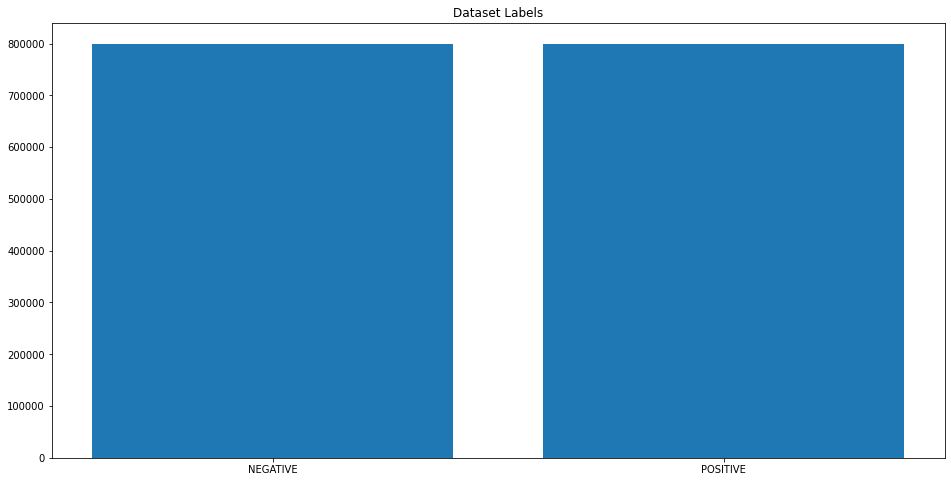

In [ ]:
from collections import Counter
target_count = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(),target_count.values())
plt.title("Dataset Labels")

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def pre_process(text, stem = False):
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip() #Cleaning the text
  tokens = []
  for token in text.split():
    #if token not in stop_words:
    if stem:
      tokens.append(stemmer.stem(token))
    else: tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: pre_process(x))

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape,df_test.shape

((1280000, 6), (320000, 6))

WORD2VEC

In [ ]:
%%time
documents = [text_.split() for text_ in df_train.text]
documents[0]

CPU times: user 3.21 s, sys: 416 ms, total: 3.63 s
Wall time: 3.63 s


In [ ]:
import gensim

w2v_model = gensim.models.word2vec.Word2Vec(size=300,window=7,min_count=10,workers=8)

In [ ]:
%%time
w2v_model.build_vocab(documents)

CPU times: user 9.35 s, sys: 63 ms, total: 9.41 s
Wall time: 9.42 s


In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab Size", vocab_size)
words

Vocab Size 30520


dict_keys(['with', 'ya', 'quot', 'i', 'd', 'like', 'a', 'palm', 'pre', 'charger', 'yes', 'that', 'sounds', 'good', 'but', 'is', 'my', 'beer', 'ready', 'now', 'prelaunch', 'felt', 'the', 'earthquake', 'this', 'afternoon', 'it', 'seems', 'to', 'be', 'at', 'on', 'shirts', 'are', 'so', 'in', 'me', 'likey', 'pretty', 'bad', 'night', 'into', 'crappy', 'morning', 'fml', 'if', 'only', 'didnt', 'say', 'he', 'could', 'go', 'work', 'today', 'yeah', 'what', 'clear', 'view', 'one', 'more', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'will', 'added', 'next', 'tm', 'video', 'please', 'met', 'your', 'fiancee', 'ian', 's', 'party', 'other', 'day', 'btw', 'she', 'very', 'sweet', 'congrats', 'you', 'guys', 'gawd', 'they', 've', 'finished', 'whole', 'bowl', 'before', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'll', 'finish', 'and', 'craving', 'for', 'god', 'of', 'war', 'action', 'happy', 'mothers', 'all', 'grown', 'n', 'a

In [ ]:
%%time
w2v_model.train(documents,total_examples=len(documents), epochs=32)

CPU times: user 31min 1s, sys: 6.95 s, total: 31min 8s
Wall time: 15min 48s


(406712985, 540038688)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.6630854606628418),
 ('looove', 0.6450487375259399),
 ('adore', 0.641467809677124),
 ('loveee', 0.607525110244751),
 ('miss', 0.5981420278549194),
 ('loved', 0.592091977596283),
 ('loooove', 0.5918611884117126),
 ('loves', 0.5914469957351685),
 ('lovee', 0.5651859045028687),
 ('loove', 0.535171389579773)]

RNN

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, LSTM, GRU, Embedding, Flatten,Conv1D, MaxPool1D
from keras import  utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print('Total Words', vocab_size)

Total Words 290572
CPU times: user 18.8 s, sys: 128 ms, total: 18.9 s
Wall time: 18.9 s


In [ ]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

CPU times: user 27.2 s, sys: 554 ms, total: 27.8 s
Wall time: 27.8 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_train.shape, y_test.shape

((1280000, 1), (320000, 1))

Embedding Layer

In [ ]:
for word, i in tokenizer.word_index.items():
  print('WWWWW:',word)
  print('III:',i)
  print(w2v_model.wv[word])
  print('________________')
  if i==5: break

WWWWW: i
III: 1
[ 3.4835835  -1.2299776  -3.5370498  -0.5386127   0.23959686  2.3450384
  2.5062182  -0.9843613   1.0677048  -1.0394992   0.93068314 -2.996571
  0.74417126  1.0829884   1.3952763  -0.09445272  1.7725956  -2.143535
  0.4590804   1.0771501  -1.6345308  -0.7366205  -1.028888    1.2231703
 -0.7032956  -0.79573697  0.0384612  -0.8417785   0.5146729  -0.06639511
  0.7233892   1.8288592  -1.0756818  -1.151312   -0.5515893   0.03173248
  0.4521578   0.36661237 -0.6289976   0.6922503   1.7789869  -1.4112716
  0.7240466   2.6882277   0.38081956  0.5353717  -0.15068118  1.6582414
  1.3907849  -0.03895726 -1.5573057   1.3367494  -0.99050456 -0.14167443
  0.34397128  0.8869164   1.6832291  -2.3045251   0.62419134 -0.3055725
 -2.3385983   1.2803794  -0.54866004  0.72373605 -0.34606704 -1.4423305
 -1.1734533  -0.986235    0.91093504  0.95469743 -0.62632     1.2967137
 -0.80699205 -1.1761583   1.2649288   1.6793615   0.57689536  0.779198
 -0.65760905  0.980288   -0.38562799  0.39721784

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_matrix.shape, embedding_matrix[:10]

((290572, 300),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 3.48358345, -1.22997761, -3.53704977, ..., -0.76835293,
         -4.14981461,  0.74484861],
        [-1.41116142, -1.29826236, -1.76062691, ..., -0.9835521 ,
         -2.46271372, -0.21685311],
        ...,
        [-1.59057164,  0.91355413,  0.27212477, ..., -1.51979887,
         -0.4391304 ,  0.9307754 ],
        [ 0.93973714, -1.0058341 , -3.67612648, ..., -0.08811981,
         -1.91795516, -0.33364323],
        [ 1.79205477, -1.41417241,  0.52430499, ...,  1.53907549,
         -0.69798911,  0.22067666]]))

In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix],input_length=300, trainable=False)

In [ ]:
#Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87171600  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,332,101
Trainable params: 160,501
Non-trainable params: 87,171,600
_________________________________________________________________


In [ ]:
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(X_train, y_train, batch_size=1024,epochs=10,validation_split=0.1,verbose=1, callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - 584s 519ms/step - loss: 0.4950 - accuracy: 0.7597 - val_loss: 0.4282 - val_accuracy: 0.8050
Epoch 2/10
1125/1125 [==============================] - 579s 514ms/step - loss: 0.4479 - accuracy: 0.7902 - val_loss: 0.4182 - val_accuracy: 0.8110
Epoch 3/10
1125/1125 [==============================] - 577s 513ms/step - loss: 0.4360 - accuracy: 0.7969 - val_loss: 0.4079 - val_accuracy: 0.8155
Epoch 4/10
1125/1125 [==============================] - 585s 520ms/step - loss: 0.4292 - accuracy: 0.8007 - val_loss: 0.4026 - val_accuracy: 0.8179
Epoch 5/10
1125/1125 [==============================] - 587s 522ms/step - loss: 0.4239 - accuracy: 0.8037 - val_loss: 0.3991 - val_accuracy: 0.8201
Epoch 6/10
1125/1125 [==============================] - 592s 527ms/step - loss: 0.4212 - accuracy: 0.8055 - val_loss: 0.3972 - val_accuracy: 0.8212
Epoch 7/10
1125/1125 [==============================] - 588s 523ms/step - loss: 0.4183 - accuracy: 0.8068 - val_

In [ ]:
%%time
score = model.evaluate(X_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 54s 173ms/step - loss: 0.3950 - accuracy: 0.8237

ACCURACY: 0.8236687779426575
LOSS: 0.3949592113494873
CPU times: user 49.8 s, sys: 3.18 s, total: 53 s
Wall time: 54.7 s


In [ ]:
def predict(text):
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
  pred = model.predict([x_test])[0]
  return pred

In [ ]:
predict("I love movies")

array([0.98897356], dtype=float32)

In [ ]:
predict("I hate drama")

array([0.00905579], dtype=float32)

In [ ]:
predict("COVID is bad")

array([0.04635994], dtype=float32)

In [ ]:
predict("COVID is not good")

array([0.02419774], dtype=float32)

In [ ]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each